# Output Analysis

This notebook contains the basic result analysis.

Before running this notebook, run `preload-train-ratings.R` to prepare intermediate data files.

## Setup

Libraries:

In [1]:
library(MASS)
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Options:

In [2]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

Utilities:

In [3]:
source("plot-tools.R")

### Demographic Utilities

We need to be able to normalize ages.

In [4]:
ml_age_bins = c("1"="1-17", "18"="18-24", "25"="25-34", "35"="35-44", "45"="45-49", "50"="50-55", "56"="56+")
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)

Function to bound numeric ages:

In [5]:
bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_bins[selectors], levels=ml_age_bins, ordered=TRUE)
}

Function to rename MovieLens age lower bounds:

In [6]:
rename_ages = function(ages) {
    stopifnot(is.character(ages))
    factor(ml_age_bins[ages], levels=ml_age_bins, ordered=TRUE)
}

## Read Data

### User Data

First, we need to read the user data from the underlying MovieLens data:

In [7]:
users.meta.ml = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=rename_ages(age),
           occupation=as.factor(occupation))
users.meta.ml

user,gender,age,occupation,zip
1,F,1-17,10,48067
2,M,56+,16,70072
3,M,25-34,15,55117
4,M,45-49,7,02460
5,M,25-34,20,55455
⋮,⋮,⋮,⋮,⋮
6036,F,25-34,15,32603
6037,F,45-49,1,76006
6038,F,56+,1,14706
6039,F,45-49,0,01060


Do the same thing with Last.FM:

In [8]:
users.meta.360k = read_csv("build/lastfm-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)

users.meta.360k

Parsed with column specification:
cols(
  id = col_integer(),
  key = col_character(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,F,18-24
2,F,NA
3,NA,NA
4,M,18-24
5,M,25-34
⋮,⋮,⋮
359343,M,25-34
359344,M,25-34
359345,M,18-24
359346,M,18-24


In [9]:
users.meta.1k = read_csv("build/lfm1k-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)
users.meta.1k

Parsed with column specification:
cols(
  id = col_integer(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,M,NA
2,F,NA
3,M,18-24
4,F,NA
5,M,NA
⋮,⋮,⋮
988,F,NA
989,M,NA
990,M,NA
991,F,NA


Merge together the metadata.

In [10]:
users.meta = 
    bind_rows(ML1M=users.meta.ml,
              LFM360K=users.meta.360k,
              LFM1K=users.meta.1k,
              .id="DataSet")
users.meta

DataSet,user,gender,age,occupation,zip
ML1M,1,F,1-17,10,48067
ML1M,2,M,56+,16,70072
ML1M,3,M,25-34,15,55117
ML1M,4,M,45-49,7,02460
ML1M,5,M,25-34,20,55455
⋮,⋮,⋮,⋮,⋮,⋮
LFM1K,988,F,NA,NA,NA
LFM1K,989,M,NA,NA,NA
LFM1K,990,M,NA,NA,NA
LFM1K,991,F,NA,NA,NA


### User Profile Statistics

Now, we want to get user profile statistics. In order to do that, we need each user's train profile; we can load that from the training data output by the cross-folding process.  The `preload-train-ratings.R` script pre-processes that data so we don't have to spend as much time doing it here.

For each partition, we loaded the _train ratings_ (historical profile) for all the _test users_ in that partition. So we will load the test data (to get the users) and the train data (to get the histories), then merge them.

In [11]:
load("build/ml1m-train.Rdata")
ml1m.train.ratings

user,part,item,rating,timestamp
1,1,1193,5,978300760
1,1,2028,5,978301619
1,1,1035,5,978301753
1,1,919,4,978301368
1,1,720,3,978300760
⋮,⋮,⋮,⋮,⋮
6038,5,1136,4,956707708
6038,5,356,4,956707005
6038,5,1079,5,956707547
6038,5,3396,3,956706827


In [12]:
load("build/lfm360k-train.Rdata")
lfm360k.train.counts

user,part,item,count
51,1,417,1162
51,1,278,365
51,1,355,320
51,1,1753,246
51,1,1491,218
⋮,⋮,⋮,⋮
359321,5,10984,72
359321,5,5234,66
359321,5,2333,66
359321,5,175,65


In [13]:
load("build/lfm1k-train.Rdata")
lfm1k.train.counts

user,part,item,count
3,1,2174,8
3,1,2167,3
3,1,2426,3
3,1,2143,7
3,1,2179,1
⋮,⋮,⋮,⋮
983,5,176619,17
983,5,1311,1
983,5,20175,28
983,5,10092,4


Now we want to compute per-user profile statistics.

In [14]:
ml.user.stats = ml1m.train.ratings %>%
    group_by(user) %>%
    summarize(nitems = n(), meanRating=mean(rating), ratingVar=var(rating))
ml.user.stats

user,nitems,meanRating,ratingVar
1,48,4.166667,0.4822695
2,124,3.717742,1.0009835
3,46,3.869565,0.9159420
4,16,4.062500,1.2625000
5,193,3.129534,1.2904253
⋮,⋮,⋮,⋮
6036,883,3.305776,1.0492523
6037,197,3.725888,0.7816223
6038,15,4.200000,0.6000000
6039,118,3.872881,0.5221643


In [15]:
lfm360k.user.stats = lfm360k.train.counts %>%
    group_by(user) %>%
    summarize(nitems=n(), medCount=median(count))
lfm360k.user.stats

user,nitems,medCount
39,38,1.0
51,69,92.0
63,39,66.0
77,45,432.0
86,48,97.5
⋮,⋮,⋮
359322,49,61.0
359324,44,5.5
359332,44,229.0
359344,43,67.0


In [16]:
lfm1k.user.stats = lfm1k.train.counts %>%
    group_by(user) %>%
    summarize(nitems=n(), medCount=median(count))
lfm1k.user.stats

user,nitems,medCount
1,658,4
2,1287,5
3,940,4
4,1774,3
5,1081,3
⋮,⋮,⋮
988,145,10
989,124,3
990,599,7
991,507,5


In [17]:
user.stats =
    bind_rows(ML1M=ml.user.stats,
              LFM360K=lfm360k.user.stats,
              LFM1K=lfm1k.user.stats,
              .id="DataSet") %>%
    select(DataSet, user, nitems)
user.stats

DataSet,user,nitems
ML1M,1,48
ML1M,2,124
ML1M,3,46
ML1M,4,16
ML1M,5,193
⋮,⋮,⋮
LFM1K,988,145
LFM1K,989,124
LFM1K,990,599
LFM1K,991,507


Join these statistics with our user metadata table, so that we have one table of user information:

In [18]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = c("DataSet", "user")


DataSet,user,gender,age,occupation,zip,nitems
ML1M,1,F,1-17,10,48067,48
ML1M,2,M,56+,16,70072,124
ML1M,3,M,25-34,15,55117,46
ML1M,4,M,45-49,7,02460,16
ML1M,5,M,25-34,20,55455,193
⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM1K,988,F,NA,NA,NA,145
LFM1K,989,M,NA,NA,NA,124
LFM1K,990,M,NA,NA,NA,599
LFM1K,991,F,NA,NA,NA,507


Now that we have user information, we can read the per-user recommender evaluation results.

In [19]:
ml.user.results = read_csv("build/movielens-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    filter(DataSet == "ML-1M") %>%
    mutate(DataSet = "ML1M")
ml.user.results

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  Rank = col_integer(),
  `1R.nDCG` = col_character(),
  `1R.Rank` = col_character(),
  `1R.RecipRank` = col_character(),
  `1R.AvgPrec` = col_character()
)
See spec(...) for full column specifications.


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,L100.AvgPrec,TopN.ActualLength,nDCG,Rank,RecipRank,AvgPrec,1R.nDCG,1R.Rank,1R.RecipRank,1R.AvgPrec
ML1M,1,UU-B,4031,4.468,NA,1.0000000,0.9514849,1,1.0000000,0.8400000,3641,0.9514849,1,1.0000000,0.84000000,NA,NA,NA,NA
ML1M,1,UU-B,4032,4.369,NA,1.0000000,0.3076758,3,0.3333333,0.1566567,3551,0.3588925,3,0.3333333,0.09975443,NA,NA,NA,NA
ML1M,1,UU-B,4033,5.327,NA,0.9377782,0.1819110,5,0.2000000,0.0835704,3047,0.2648284,5,0.2000000,0.05979684,NA,NA,NA,NA
ML1M,1,UU-B,4034,4.325,NA,0.9960107,0.3159364,4,0.2500000,0.1385401,3599,0.3562374,4,0.2500000,0.11792425,NA,NA,NA,NA
ML1M,1,UU-B,4039,4.227,NA,0.9622759,0.3506601,4,0.2500000,0.1783964,3653,0.3668631,4,0.2500000,0.14428941,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,2,UU-B,4718,3.661,NA,0.9587917,0.53754510,1,1.00000000,0.50923873,3572,0.5737869,1,1.00000000,0.41132799,NA,NA,NA,NA
ML1M,2,UU-B,5785,3.673,NA,0.9750893,0.60381706,1,1.00000000,0.69230769,3579,0.6621133,1,1.00000000,0.42173079,NA,NA,NA,NA
ML1M,2,UU-B,4724,3.199,NA,0.9596196,0.21088044,6,0.16666667,0.10123457,3665,0.2829845,6,0.16666667,0.07509063,NA,NA,NA,NA
ML1M,2,UU-B,5875,3.642,NA,0.9480569,0.12162662,17,0.05882353,0.06389452,3572,0.2138171,17,0.05882353,0.03195783,NA,NA,NA,NA


In [20]:
lfm360k.user.results = read_csv("build/lastfm-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    filter(!startsWith(Algorithm, "UU-")) %>%
    mutate(DataSet = "LFM360K")
lfm360k.user.results

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  L10K.Rank = col_integer(),
  Rank = col_integer()
)
See spec(...) for full column specifications.


DataSet,Partition,Algorithm,user,TestTime,Rank.nDCG,L100.Rank,L100.RecipRank,L100.nDCG,L100.AvgPrec,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,TopN.ActualLength,Rank,RecipRank,nDCG,AvgPrec
LFM360K,3,Pop-B,240341,0.295,0.9465068,24,0.04166667,0.05312397,0.04166667,10000,24,0.041666667,0.1574600,0.011191865,160072,24,0.041666667,0.1574600,0.011191865
LFM360K,5,Pop-B,236784,0.253,0.9713948,1,1.00000000,0.55551107,1.00000000,10000,1,1.000000000,0.6242532,0.203967812,160064,1,1.000000000,0.6242532,0.203967812
LFM360K,3,Pop-B,240385,0.160,0.9437744,NA,0.00000000,0.00000000,0.00000000,10000,147,0.006802721,0.1341641,0.002588464,160081,147,0.006802721,0.1341641,0.002588464
LFM360K,5,Pop-B,236807,0.159,0.7971288,NA,0.00000000,0.00000000,0.00000000,10000,250,0.004000000,0.1126438,0.003236253,160067,250,0.004000000,0.1168260,0.002659754
LFM360K,5,Pop-B,236832,0.362,0.9824342,NA,0.00000000,0.00000000,0.00000000,10000,237,0.004219409,0.1135632,0.002595432,160068,237,0.004219409,0.1238348,0.002150343
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K,1,MF-B,339766,0.280,0.8019852,NA,0,0,0,10000,731,0.0013679891,0.10262828,0.0012494087,160075,731,0.0013679891,0.10262828,0.0012494087
LFM360K,1,MF-B,348467,0.280,0.9181683,NA,0,0,0,10000,631,0.0015847861,0.10745371,0.0018584157,160072,631,0.0015847861,0.10745371,0.0018584157
LFM360K,1,MF-B,339871,0.279,0.8576777,NA,0,0,0,10000,1467,0.0006816633,0.10510195,0.0006760859,160078,1467,0.0006816633,0.10510195,0.0006760859
LFM360K,1,MF-B,348600,0.279,0.8202323,NA,0,0,0,10000,736,0.0013586957,0.05545414,0.0007958755,160086,736,0.0013586957,0.08917866,0.0005276569


In [21]:
lfm1k.user.results = read_csv("build/lfm1k-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    filter(!startsWith(Algorithm, "UU-")) %>%
    mutate(DataSet = "LFM1K")
lfm1k.user.results

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  L10K.Rank = col_integer(),
  Rank = col_integer()
)
See spec(...) for full column specifications.


DataSet,Partition,Algorithm,user,TestTime,Rank.nDCG,L100.Rank,L100.RecipRank,L100.nDCG,L100.AvgPrec,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,TopN.ActualLength,Rank,RecipRank,nDCG,AvgPrec
LFM1K,5,Pop-B,692,0.851,0.9957313,6,0.16666667,0.3422255,0.16666667,10000,6,0.166666667,0.35419067,0.059239026,175736,6,0.166666667,0.35678667,0.0355732711
LFM1K,4,Pop-C,645,0.356,0.7463263,NA,0.00000000,0.0000000,0.00000000,10000,1996,0.000501002,0.04479647,0.000353846,174742,1996,0.000501002,0.07883371,0.0003002071
LFM1K,5,Pop-C,692,0.360,0.9972090,21,0.04761905,0.2014062,0.04761905,10000,21,0.047619048,0.21145835,0.017466984,175736,21,0.047619048,0.21408166,0.0105031120
LFM1K,3,Pop-C,585,0.385,0.9615427,1,1.00000000,0.1208657,1.00000000,10000,1,1.000000000,0.24343652,0.204534246,176358,1,1.000000000,0.24343652,0.2045342465
LFM1K,4,Pop-B,645,0.910,0.7463263,NA,0.00000000,0.0000000,0.00000000,10000,500,0.002000000,0.05150987,0.001146092,174742,500,0.002000000,0.09006103,0.0007068257
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM1K,1,II-B,531,6.733,0.8790780,NA,0.00000000,0.0000000,0.00000000,10000,687,0.0014556041,0.052508436,0.0009179884,64999,687,0.0014556041,0.09036178,5.185396e-04
LFM1K,1,II-B,235,4.315,0.8924490,55,0.01818182,0.1061252,0.02007992,10000,55,0.0181818182,0.150437396,0.0117029627,65573,55,0.0181818182,0.15043740,1.170296e-02
LFM1K,1,II-B,793,11.716,0.5856374,NA,0.00000000,0.0000000,0.00000000,10000,7973,0.0001254233,0.003569748,0.0001254233,63444,7973,0.0001254233,0.04178119,9.837568e-05
LFM1K,1,II-B,162,4.841,0.7769084,NA,0.00000000,0.0000000,0.00000000,10000,389,0.0025706941,0.104954434,0.0029494732,65726,389,0.0025706941,0.10495443,2.949473e-03


In [22]:
user.results = 
    bind_rows(ml.user.results, lfm1k.user.results, lfm360k.user.results) %>%
    inner_join(users)
user.results

Joining, by = c("DataSet", "user")


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,⋯,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,gender,age,occupation,zip,nitems
ML1M,1,UU-B,4031,4.468,NA,1.0000000,0.9514849,1,1.0000000,⋯,NA,NA,NA,NA,NA,M,25-34,0,42445,46
ML1M,1,UU-B,4032,4.369,NA,1.0000000,0.3076758,3,0.3333333,⋯,NA,NA,NA,NA,NA,M,25-34,12,56301,148
ML1M,1,UU-B,4033,5.327,NA,0.9377782,0.1819110,5,0.2000000,⋯,NA,NA,NA,NA,NA,M,25-34,6,43551,657
ML1M,1,UU-B,4034,4.325,NA,0.9960107,0.3159364,4,0.2500000,⋯,NA,NA,NA,NA,NA,M,25-34,0,21113,103
ML1M,1,UU-B,4039,4.227,NA,0.9622759,0.3506601,4,0.2500000,⋯,NA,NA,NA,NA,NA,M,25-34,16,97401,48
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K,1,MF-B,339766,0.280,NA,0.8019852,0,NA,0,⋯,10000,731,0.0013679891,0.10262828,0.0012494087,M,18-24,NA,NA,42
LFM360K,1,MF-B,348467,0.280,NA,0.9181683,0,NA,0,⋯,10000,631,0.0015847861,0.10745371,0.0018584157,NA,18-24,NA,NA,45
LFM360K,1,MF-B,339871,0.279,NA,0.8576777,0,NA,0,⋯,10000,1467,0.0006816633,0.10510195,0.0006760859,F,NA,NA,NA,39
LFM360K,1,MF-B,348600,0.279,NA,0.8202323,0,NA,0,⋯,10000,736,0.0013586957,0.05545414,0.0007958755,F,18-24,NA,NA,31


In [23]:
write_csv(user.results, "build/integrated-user-results.csv")

In [24]:
overall.results = user.results %>%
    select(DataSet, Algorithm, RecipRank, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm) %>%
    summarize(nDCG=mean(nDCG), MRR=mean(RecipRank), Rank.nDCG=mean(Rank.nDCG)) %>%
    ungroup()

In [25]:
best.algos = overall.results %>%
    group_by(DataSet) %>%
    summarize(BestNDCG=max(nDCG),
              BestAlgo=Algorithm[which.max(nDCG)])
best.algos

DataSet,BestNDCG,BestAlgo
LFM1K,0.1558515,II-B
LFM360K,0.3001435,II-B
ML1M,0.3478020,UU-B


In [26]:
best.results = best.algos %>%
    select(DataSet, BestAlgo) %>%
    inner_join(user.results) %>%
    filter(Algorithm == BestAlgo) %>%
    select(-BestAlgo)
best.results

Joining, by = "DataSet"


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,⋯,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,gender,age,occupation,zip,nitems
LFM1K,5,II-B,692,4.749,NA,0.9819604,0.20468645,20,0.05000000,⋯,10000,20,0.0500000000,0.21838389,0.023626001,NA,NA,NA,NA,1197
LFM1K,5,II-B,694,2.861,NA,0.7451547,0.02824604,56,0.01785714,⋯,10000,56,0.0178571429,0.10606109,0.005517001,M,NA,NA,NA,501
LFM1K,5,II-B,690,3.059,NA,0.7414247,0.00000000,NA,0.00000000,⋯,10000,200,0.0050000000,0.10058135,0.002946950,F,NA,NA,NA,582
LFM1K,5,II-B,711,6.017,NA,0.8322899,0.00000000,NA,0.00000000,⋯,10000,1678,0.0005959476,0.07766624,0.000745201,F,NA,NA,NA,1026
LFM1K,5,II-B,712,1.661,NA,0.9278452,0.00000000,NA,0.00000000,⋯,10000,200,0.0050000000,0.12720390,0.004638345,M,NA,NA,NA,215
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,2,UU-B,4718,3.661,NA,0.9587917,0.53754510,1,1.00000000,⋯,NA,NA,NA,NA,NA,M,35-44,7,03885,133
ML1M,2,UU-B,5785,3.673,NA,0.9750893,0.60381706,1,1.00000000,⋯,NA,NA,NA,NA,NA,F,25-34,7,60607,125
ML1M,2,UU-B,4724,3.199,NA,0.9596196,0.21088044,6,0.16666667,⋯,NA,NA,NA,NA,NA,F,56+,6,01852,28
ML1M,2,UU-B,5875,3.642,NA,0.9480569,0.12162662,17,0.05882353,⋯,NA,NA,NA,NA,NA,M,25-34,4,19103,133


## Gender

Let's analyze accuracy by gender.

In [27]:
gender.results = user.results %>%
    select(DataSet, Algorithm, gender, RecipRank, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, gender) %>%
    summarize(nDCG=mean(nDCG), Rank.nDCG=mean(Rank.nDCG), MRR=mean(RecipRank)) %>%
    ungroup()
head(gender.results)

DataSet,Algorithm,gender,nDCG,Rank.nDCG,MRR
LFM1K,II-B,F,0.18379674,0.8234126,0.124055578
LFM1K,II-B,M,0.13810004,0.7854049,0.077049650
LFM1K,II-B,NA,0.14029112,0.7925350,0.063715005
LFM1K,II-C,F,0.08752032,0.8395035,0.002545079
LFM1K,II-C,M,0.08121656,0.7990015,0.002747112
LFM1K,II-C,NA,0.08723427,0.8230358,0.004032184


In [28]:
combined.results = bind_rows(gender.results,
                             overall.results %>% mutate(gender = 'Any')) %>%
    inner_join(best.algos %>% select(DataSet, BestAlgo)) %>%
    mutate(IsBest = Algorithm == BestAlgo)
head(combined.results)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Joining, by = "DataSet"


DataSet,Algorithm,gender,nDCG,Rank.nDCG,MRR,BestAlgo,IsBest
LFM1K,II-B,F,0.18379674,0.8234126,0.124055578,II-B,TRUE
LFM1K,II-B,M,0.13810004,0.7854049,0.077049650,II-B,TRUE
LFM1K,II-B,NA,0.14029112,0.7925350,0.063715005,II-B,TRUE
LFM1K,II-C,F,0.08752032,0.8395035,0.002545079,II-B,FALSE
LFM1K,II-C,M,0.08121656,0.7990015,0.002747112,II-B,FALSE
LFM1K,II-C,NA,0.08723427,0.8230358,0.004032184,II-B,FALSE


What does the nDCG look like?

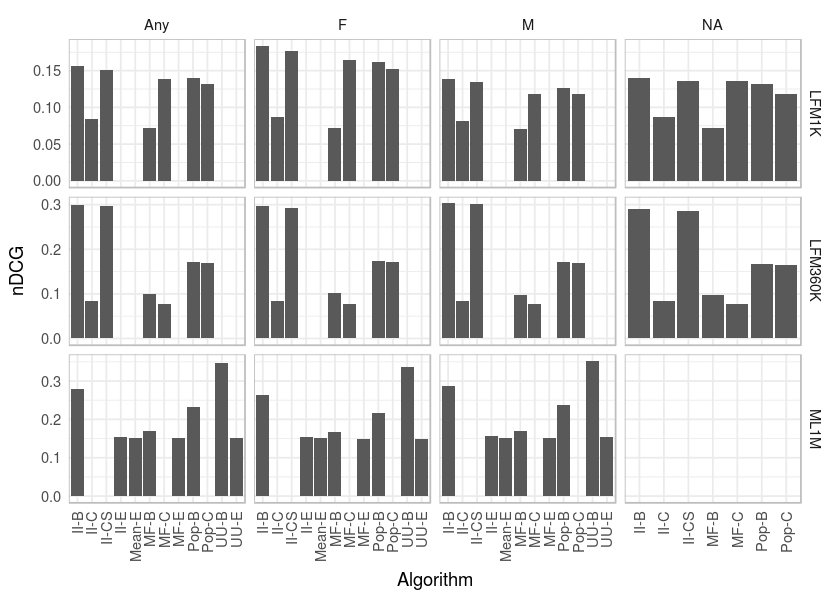

In [29]:
ggplot(combined.results) +
    aes(x=Algorithm, y=nDCG) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ gender, scales="free") +
    theme_paper() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

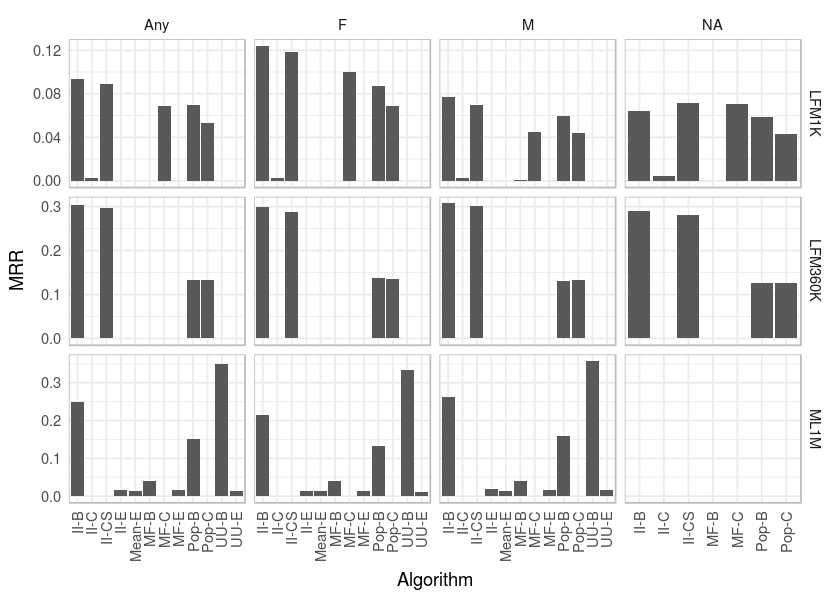

In [30]:
ggplot(combined.results) +
    aes(x=Algorithm, y=MRR) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ gender, scales="free") +
    theme_paper() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

For the paper, we need to split the nDCG plots into separate MovieLens and Last.FM charts.

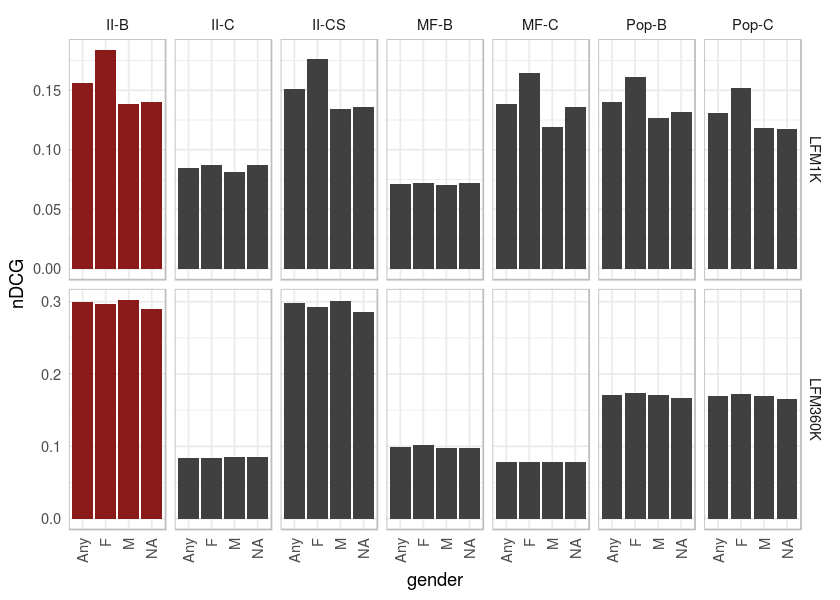

In [31]:
make.plot("basic-gender-ndcg-lfm", width=5.5, height=3, {
    ggplot(combined.results %>% filter(startsWith(DataSet, "LFM"))) +
        aes(x=gender, y=nDCG, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

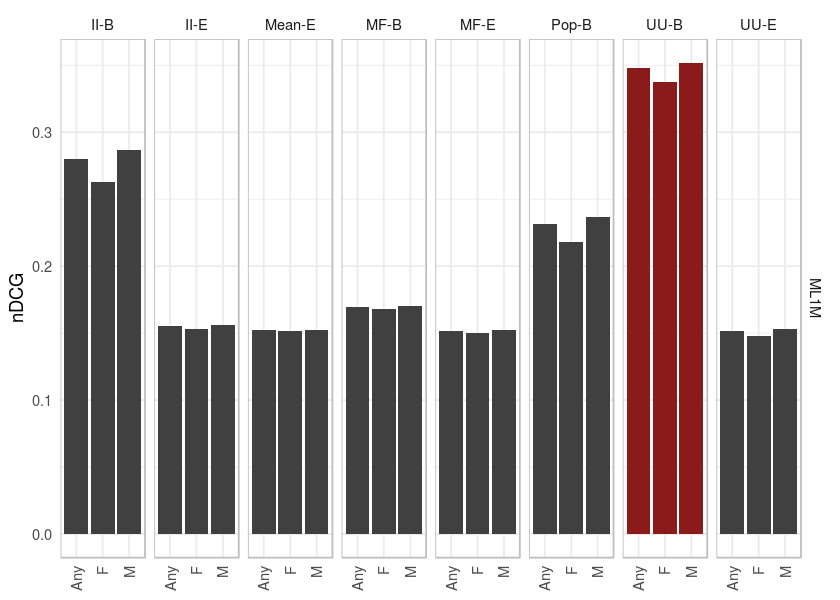

In [32]:
make.plot("basic-gender-ndcg-ml", width=5.5, height=1.9, {
    ggplot(combined.results %>% filter(startsWith(DataSet, "ML"))) +
        aes(x=gender, y=nDCG, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        xlab(NULL) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

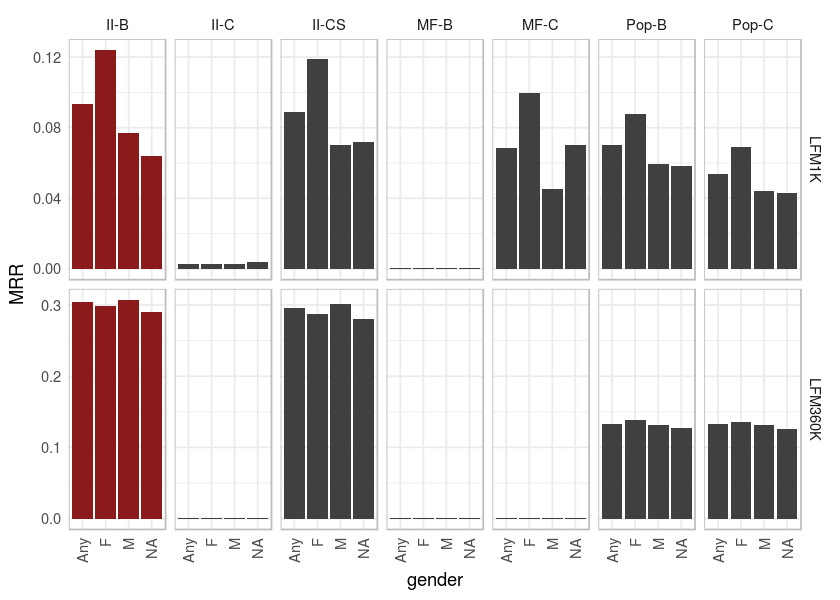

In [33]:
make.plot("basic-gender-mrr-lfm", width=5.5, height=3, {
    ggplot(combined.results %>% filter(startsWith(DataSet, "LFM"))) +
        aes(x=gender, y=MRR, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

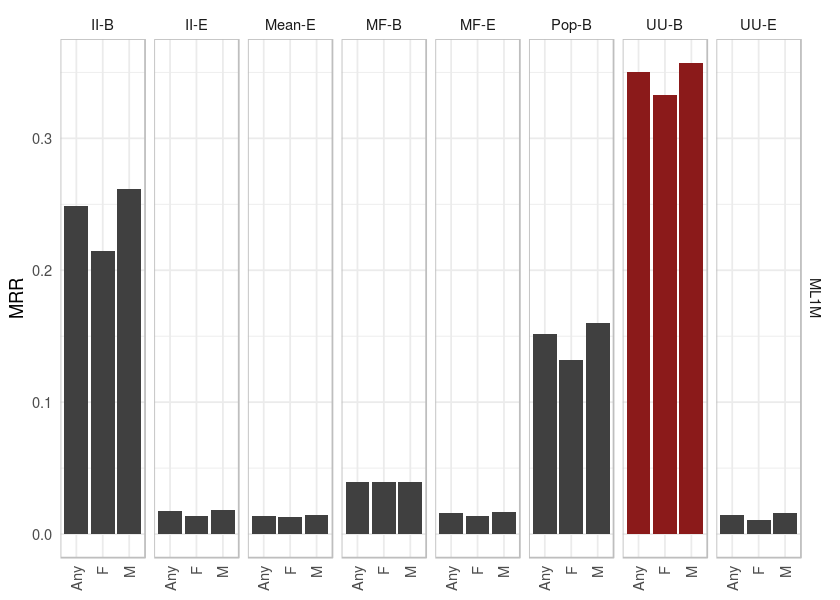

In [34]:
make.plot("basic-gender-mrr-ml", width=5.5, height=1.9, {
    ggplot(combined.results %>% filter(startsWith(DataSet, "ML"))) +
        aes(x=gender, y=MRR, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        xlab(NULL) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

Signifcance testing! We tried ANOVA, and the assumptions were awful. So we will use the Kruskal-Wallis test.

We want $p < 0.01$; with 10 comparisons (5 here, and another ~5 in the gender-balanced case) the Bonferonni correction says that we need $p < 0.002$ for individual tests.

In [35]:
kruskal.test(nDCG ~ gender, filter(best.results, DataSet == "ML1M"))


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 11.589, df = 1, p-value = 0.0006633


In [36]:
kruskal.test(nDCG ~ gender, filter(best.results, DataSet == "LFM1K"))


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 30.572, df = 1, p-value = 3.217e-08


In [37]:
kruskal.test(nDCG ~ gender, filter(best.results, DataSet == "LFM360K"))


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 5.5963, df = 1, p-value = 0.018


## Age

We now want to examine accuracy as a function of age. We're basically going to do the same thing we did for gender.

Start by aggregating the results:

In [38]:
age.results = user.results %>%
    select(DataSet, Algorithm, age, RecipRank, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, age) %>%
    summarize(nDCG=mean(nDCG), Rank.nDCG=mean(Rank.nDCG), MRR=mean(RecipRank)) %>%
    ungroup()
head(age.results)

DataSet,Algorithm,age,nDCG,Rank.nDCG,MRR
LFM1K,II-B,1-17,0.17420873,0.7694089,0.0688874556
LFM1K,II-B,18-24,0.14878506,0.7792607,0.0834104181
LFM1K,II-B,25-34,0.16296110,0.8204166,0.1085121334
LFM1K,II-B,35-44,0.11641423,0.7537059,0.0356717224
LFM1K,II-B,45-49,0.10672324,0.7170978,0.0051613160
LFM1K,II-B,50-55,0.07057164,0.7959761,0.0002644803


In [39]:
age.combined.results = bind_rows(age.results, overall.results %>% mutate(age = 'Any')) %>%
    inner_join(best.algos) %>%
    mutate(IsBest = Algorithm == BestAlgo)
head(age.combined.results)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Joining, by = "DataSet"


DataSet,Algorithm,age,nDCG,Rank.nDCG,MRR,BestNDCG,BestAlgo,IsBest
LFM1K,II-B,1-17,0.17420873,0.7694089,0.0688874556,0.1558515,II-B,TRUE
LFM1K,II-B,18-24,0.14878506,0.7792607,0.0834104181,0.1558515,II-B,TRUE
LFM1K,II-B,25-34,0.16296110,0.8204166,0.1085121334,0.1558515,II-B,TRUE
LFM1K,II-B,35-44,0.11641423,0.7537059,0.0356717224,0.1558515,II-B,TRUE
LFM1K,II-B,45-49,0.10672324,0.7170978,0.0051613160,0.1558515,II-B,TRUE
LFM1K,II-B,50-55,0.07057164,0.7959761,0.0002644803,0.1558515,II-B,TRUE


And then we can plot them:

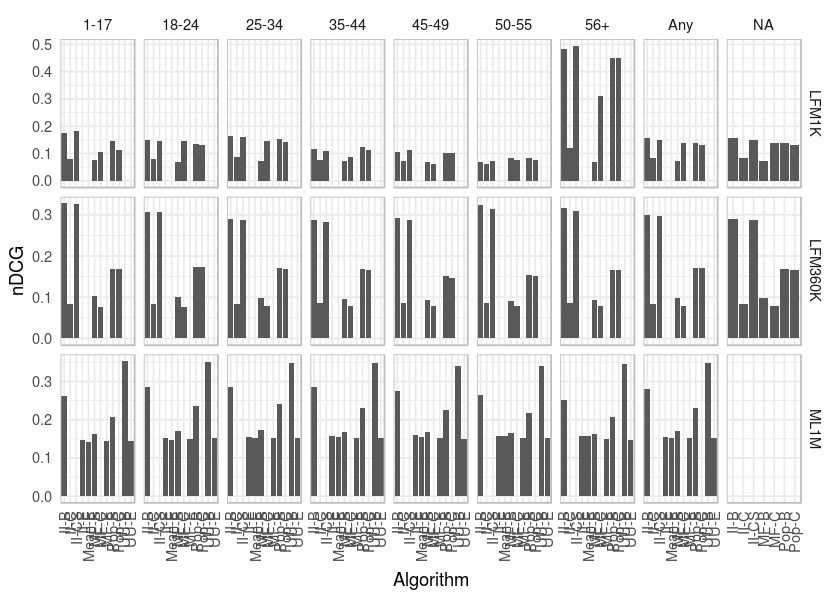

In [40]:
ggplot(age.combined.results) +
    aes(x=Algorithm, y=nDCG) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ age, scales="free") +
    theme_paper() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

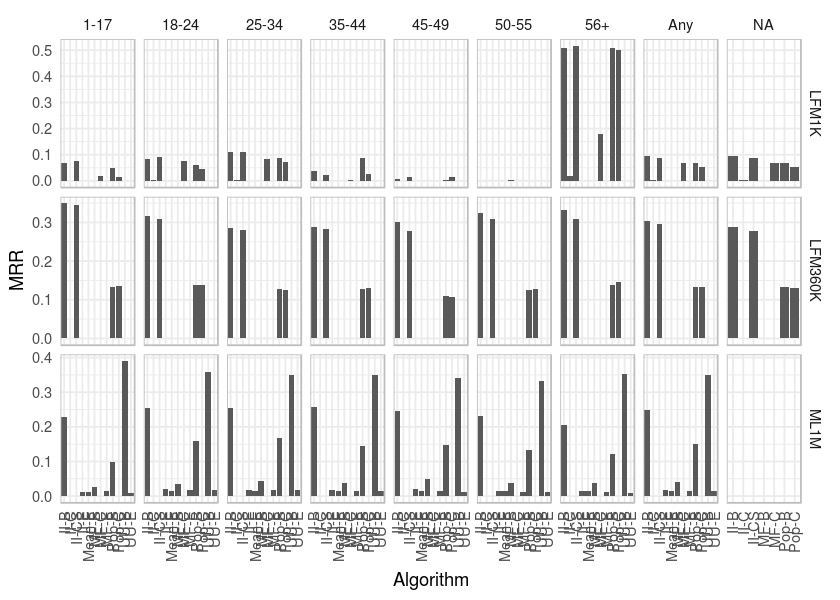

In [41]:
ggplot(age.combined.results) +
    aes(x=Algorithm, y=MRR) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ age, scales="free") +
    theme_paper() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

Let's split apart for the paper though.

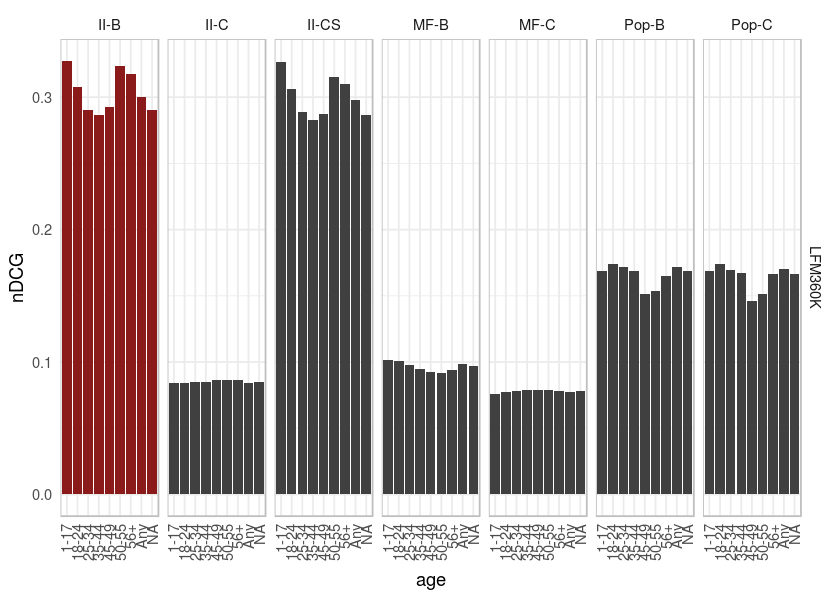

In [42]:
make.plot("basic-age-ndcg-lfm", width=9, height=2.1, {
    ggplot(age.combined.results %>% filter(DataSet == "LFM360K")) +
        aes(x=age, y=nDCG, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

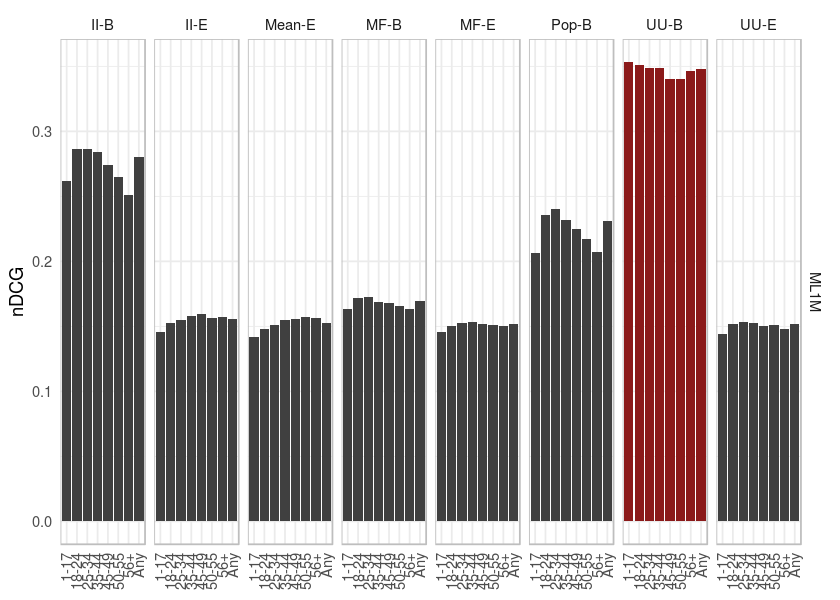

In [43]:
make.plot("basic-age-ndcg-ml", width=9, height=1.9, {
    ggplot(age.combined.results %>% filter(startsWith(DataSet, "ML"))) +
        aes(x=age, y=nDCG, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        xlab(NULL) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

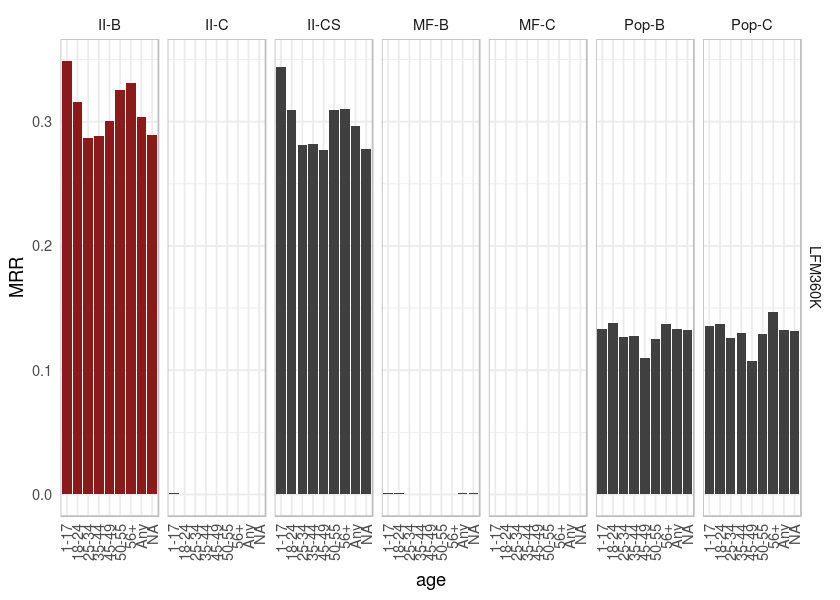

In [44]:
make.plot("basic-age-mrr-lfm", width=9, height=2.1, {
    ggplot(age.combined.results %>% filter(DataSet == "LFM360K")) +
        aes(x=age, y=MRR, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

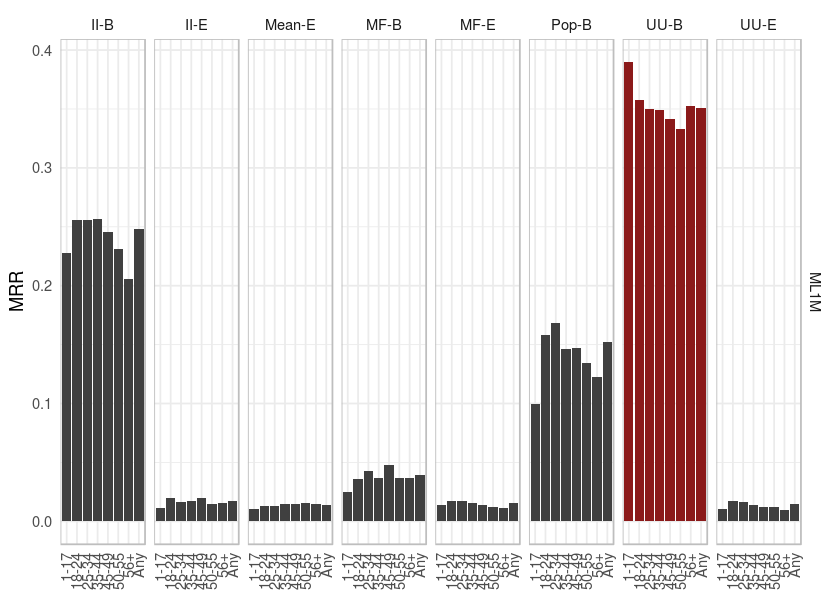

In [45]:
make.plot("basic-age-mrr-ml", width=9, height=1.9, {
    ggplot(age.combined.results %>% filter(startsWith(DataSet, "ML"))) +
        aes(x=age, y=MRR, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        xlab(NULL) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

Let's significance-test these results.

In [76]:
kruskal.test(nDCG ~ age, filter(best.results, DataSet == "ML1M"))


	Kruskal-Wallis rank sum test

data:  nDCG by age
Kruskal-Wallis chi-squared = 4.4828, df = 6, p-value = 0.6116


In [77]:
kruskal.test(nDCG ~ age, filter(best.results, DataSet == "LFM360K"))


	Kruskal-Wallis rank sum test

data:  nDCG by age
Kruskal-Wallis chi-squared = 95.66, df = 6, p-value < 2.2e-16
